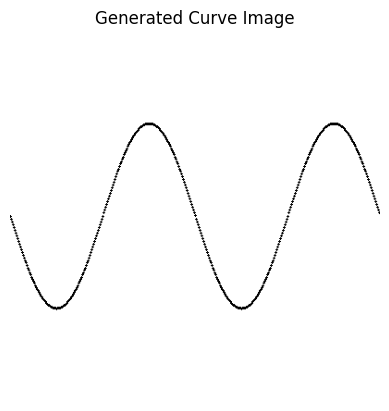

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a blank white image
img = np.ones((400, 400, 3), dtype=np.uint8) * 255

# Draw a curve (e.g., a sine wave)
for x in range(0, 400):
    y = int(200 + 100 * np.sin(x * np.pi / 100))
    cv2.circle(img, (x, y), 1, (0, 0, 0), -1)

# Convert to grayscale and threshold
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Save images for reference

folder_path = "test"
cv2.imwrite(f"{folder_path}/sine_curve.png", img)
cv2.imwrite(f"{folder_path}/sine_curve_thresh.png", thresh)

# Display the generated image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Generated Curve Image")
plt.axis("off")
plt.show()


In [8]:
import cv2
import numpy as np

def extract_path_from_image(image_path, show=False):
    # Load image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold to binary
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not contours:
        raise ValueError("No contour found")

    # Choose the longest contour (assuming it's the drawn path)
    contour = max(contours, key=lambda c: len(c))

    # Simplify contour to (x, y) points
    path = contour[:, 0, :]  # shape (N, 2)

    if show:
        display = img.copy()
        for (x, y) in path:
            cv2.circle(display, (x, y), 1, (0, 0, 255), -1)
        cv2.imshow("Path", display)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return path.tolist()

# Example usage:
if __name__ == "__main__":
    path = extract_path_from_image("test/test1.png", show=True)
    print("Extracted path:", path)


Extracted path: [[197, 135], [196, 136], [195, 136], [194, 136], [193, 136], [192, 136], [191, 137], [190, 137], [189, 137], [188, 137], [187, 138], [186, 138], [185, 138], [184, 139], [183, 139], [182, 139], [181, 140], [180, 140], [179, 141], [178, 141], [177, 142], [176, 142], [175, 143], [174, 144], [173, 144], [172, 145], [171, 146], [170, 146], [169, 147], [168, 148], [167, 149], [166, 150], [165, 151], [164, 152], [163, 153], [162, 154], [161, 155], [160, 156], [160, 157], [159, 158], [158, 159], [158, 160], [157, 161], [156, 162], [156, 163], [155, 164], [155, 165], [154, 166], [154, 167], [153, 168], [153, 169], [153, 170], [152, 171], [152, 172], [152, 173], [151, 174], [151, 175], [151, 176], [151, 177], [150, 178], [150, 179], [150, 180], [150, 181], [150, 182], [149, 183], [149, 184], [149, 185], [149, 186], [149, 187], [149, 188], [149, 189], [149, 190], [149, 191], [149, 192], [149, 193], [149, 194], [149, 195], [149, 196], [149, 197], [149, 198], [149, 199], [149, 200],

In [9]:
import matplotlib.animation as FuncAnimation

def generate_motion(path, v0=50, t0=2, dt=0.05):
    path = path.astype(np.float32)
    distances = np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1))
    total_length = np.sum(distances)
    
    # Time to travel the whole path after acceleration
    accel_distance = 0.5 * v0 * t0
    remaining_distance = total_length - accel_distance
    remaining_time = remaining_distance / v0
    total_time = t0 + remaining_time
    steps = int(total_time / dt)

    # Cumulative distance lookup
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)

    # Generate distance over time profile
    times = np.linspace(0, total_time, steps)
    distance_profile = np.piecewise(
        times,
        [times < t0, times >= t0],
        [lambda t: 0.5 * (v0 / t0) * t**2,
         lambda t: accel_distance + v0 * (t - t0)]
    )

    # Map distances to path points
    positions = []
    for d in distance_profile:
        idx = np.searchsorted(cumulative_dist, d)
        if idx >= len(path) - 1:
            idx = len(path) - 2
        ratio = (d - cumulative_dist[idx]) / distances[idx]
        point = (1 - ratio) * path[idx] + ratio * path[idx + 1]
        positions.append(point)

    return np.array(positions)

# Animation function
def animate_path(path, vehicle_positions):
    fig, ax = plt.subplots()
    ax.plot(path[:, 0], path[:, 1], 'k-', linewidth=1)
    vehicle_dot, = ax.plot([], [], 'ro', markersize=5)
    ax.set_xlim(path[:, 0].min() - 10, path[:, 0].max() + 10)
    ax.set_ylim(path[:, 1].min() - 10, path[:, 1].max() + 10)
    ax.set_aspect('equal')
    ax.set_title("Vehicle Path Animation")

    def update(frame):
        vehicle_dot.set_data(vehicle_positions[frame, 0], vehicle_positions[frame, 1])
        return vehicle_dot,

    ani = FuncAnimation(fig, update, frames=len(vehicle_positions), interval=50, blit=True)
    plt.close(fig)
    return ani

In [10]:
vehicle_positions = generate_motion(path, v0=50, t0=2, dt=0.05)
animation = animate_path(path, vehicle_positions)
animation

AttributeError: 'list' object has no attribute 'astype'